In [1]:
import json

In [2]:
# open the JSON file with paper metadata from paperswithcode
with open("../data/papers_data_original.json", "r", encoding="utf-8") as f:
    papers_list = json.load(f)
# remove if Local PDF Path is None
papers_list = [paper for paper in papers_list if paper.get("Local PDF Path") is not None]

In [3]:
# return the unique task list that appears in the papers
tasks_dataset = []
for i,paper in enumerate(papers_list):
    tasks_dataset.append(paper['Tasks id'])


# add everything in a set 
unique_labels = sorted({item for group in tasks_dataset for item in group if item})


In [4]:
len(unique_labels), unique_labels

(0, [])

In [ ]:
import requests
import time
##NOTE: THIS EXPERIMENT IS OBSOLETE NOW SINCE PWC DISCONTINUED ON JULY 25
BASE_URL = "https://paperswithcode.com/api/v1"

class TreeNode:
    def __init__(self, task_id):
        self.id = task_id
        self.children = []
        self.parents = []

    def add_child(self, node):
        self.children.append(node)

    def add_parent(self, node):
        self.parents.append(node)
        

    def __repr__(self):
        return f"TreeNode({self.id!r})"
    
    def print_tree(self, level=0, direction="down"):
        indent = "  " * level
        if direction == "down":
            print(f"{indent}- {self.id}")
            for ch in self.children:
                ch.print_tree(level+1, direction="down")
        else:
            print(f"{indent}- {self.id}")
            for p in self.parents:
                p.print_tree(level+1, direction="up")


def build_ancestor_tree(task_label, seen=None):
    """
    Recursively fetches all parents of `task_label` and returns a TreeNode.
    Each parent becomes a child of the current node, building upward.
    """
    if seen is None:
        seen = set()

    # cycle guard
    if task_label in seen:
        return TreeNode(task_label)
    seen.add(task_label)

    # create the node for this task
    node = TreeNode(task_label)

    # helper to fetch relations
    def fetch(rel):
        url = f"{BASE_URL}/tasks/{task_label.replace(' ', '-').lower()}/{rel}/"
        r = requests.get(url); r.raise_for_status()
        return [e["id"] for e in r.json().get("results", [])]
    
    # 1) parents
    parent_ids = fetch("parents")

    if not parent_ids or (len(parent_ids) == 1 and parent_ids[0] == task_label):
        return node

    for pid in parent_ids:
        parent_node = build_ancestor_tree(pid, seen)
        node.add_parent(parent_node)

        parent_node.add_child(node)

    time.sleep(1)
    # 2) children
    child_ids = fetch("children")
    if not child_ids or (len(child_ids) == 1 and child_ids[0] == task_label):
        return node

    for cid in child_ids:
        child_node = build_ancestor_tree(cid, seen)
        node.add_child(child_node)
        child_node.add_parent(node)

    return node


# --- example usage ---
if __name__ == "__main__":
    # suppose unique_labels is defined elsewhere
    for label in unique_labels[0:5]:
        print(f"\nBuilding tree for task: {label}")
        root = build_ancestor_tree(label)
        print("Ancestors (up):")
        root.print_tree(direction="up")
        print("\nDescendants (down):")
        root.print_tree(direction="down")


In [ ]:
import requests
import time
import networkx as nx

# 1) Build an empty directed graph
G = nx.DiGraph()

BASE_URL = "https://paperswithcode.com/api/v1"
# 1) Build an empty directed graph
def build_ancestor_tree(G ,task_label, seen=None, relation = None):
    """
    Recursively fetches all parents of `task_label` and returns a TreeNode.
    Each parent becomes a child of the current node, building upward.
    """
    if seen is None:
        seen = set()

    # # cycle guard
    if task_label in seen:
        return G
    seen.add(task_label)
    # create the node for this task
    if not G.has_node(task_label):
        G.add_node(task_label)


    # helper to fetch relations
    def fetch(rel):
        url = f"{BASE_URL}/tasks/{task_label.replace(' ', '-').lower()}/{rel}/"
        r = requests.get(url); r.raise_for_status()
        return [e["id"] for e in r.json().get("results", [])]
    
    if relation is None:
        # 1) parents
        parent_ids = fetch("parents")


        for pid in parent_ids:
            G = build_ancestor_tree(G, pid, seen, relation="parents")
            G.add_edge(pid, task_label)


        time.sleep(1)
        # 2) children
        child_ids = fetch("children")

        for cid in child_ids:
            G = build_ancestor_tree(G,cid, seen, relation="children")
            G.add_edge(task_label,cid)

        return G
    else:
        time.sleep(1)
        print(f"Fetching {relation} for task: {task_label}")
        # if relation is specified, we only fetch that relation
        ids = fetch(relation)
        for id in ids:
            G.add_edge(task_label, id)
            G = build_ancestor_tree(G, id, seen, relation=relation)
        return G

# --- example usage ---
if __name__ == "__main__":
    # suppose unique_labels is defined elsewhere
    i = 0
    for label in unique_labels:
        print(f"num: {i} - ", end="")
        i += 1
        print(f"\nBuilding tree for task: {label}")
        root = build_ancestor_tree(G, label)



In [21]:
root

In [ ]:
# after you build
root_label = "your‐starting‐task"
G.graph["root_label"] = root_label

# save
import pickle
with open("task_graph.pkl", "wb") as f:
    pickle.dump(G, f)


## saved nx

In [5]:
import pickle

with open("task_graph.pkl", "rb") as f:
    Graph = pickle.load(f)
root_label = Graph.graph["root_label"]

In [ ]:
# # saving
# G.graph["root_label"] = root_label
# nx.write_graphml(G, "task_graph.graphml")

# # loading
# G = nx.read_graphml("task_graph.graphml")
# root_label = G.graph.get("root_label")

In [6]:
import networkx as nx



self_loops = list(nx.selfloop_edges(Graph))
print(f"Found {len(self_loops)} self‐loops:", self_loops)


Graph.remove_edges_from(self_loops)


print("Number of self‐loops after removal:", nx.number_of_selfloops(Graph))

Found 196 self‐loops: [('active-learning', 'active-learning'), ('optical-character-recognition', 'optical-character-recognition'), ('adversarial-attack', 'adversarial-attack'), ('adversarial-text', 'adversarial-text'), ('adversarial-attack-detection', 'adversarial-attack-detection'), ('adversarial-robustness', 'adversarial-robustness'), ('question-answering', 'question-answering'), ('arc', 'arc'), ('2d-human-pose-estimation', '2d-human-pose-estimation'), ('automl', 'automl'), ('architecture-search', 'architecture-search'), ('autonomous-vehicles', 'autonomous-vehicles'), ('motion-forecasting', 'motion-forecasting'), ('bayesian-inference', 'bayesian-inference'), ('benchmarking', 'benchmarking'), ('bias-detection', 'bias-detection'), ('bilevel-optimization', 'bilevel-optimization'), ('entity-resolution', 'entity-resolution'), ('data-integration', 'data-integration'), ('anaphora-resolution', 'anaphora-resolution'), ('information-extraction', 'information-extraction'), ('open-information-ex

In [7]:
# A “top‐level” node is one whose only incoming edge, if any, is a self‐loop.
top_levels = []
for n in Graph.nodes():
    # collect all predecessors u → n where u != n
    non_self_preds = [u for u in Graph.predecessors(n) if u != n]
    if len(non_self_preds) == 0:
        top_levels.append(n)

print("Top‐level nodes:", top_levels)
print("Number of top‐level nodes:", len(top_levels))

Top‐level nodes: ['optical-character-recognition', 'adversarial-attack', 'adversarial-robustness', 'ai2-reasoning-challenge', 'question-answering', 'arc', '2d-human-pose-estimation', 'attribute', 'automl', 'autonomous-vehicles', 'bayesian-inference', 'bias-detection', 'bilevel-optimization', 'anaphora-resolution', 'caption-generation', 'named-entity-recognition-ner', 'class-incremental-learning-1', 'classification', 'click-through-rate-prediction', 'collaborative-filtering', 'common-sense-reasoning', 'computational-efficiency', 'task', 'contrastive-learning', 'counterfactual', 'counterfactual-reasoning', 'data-augmentation', 'data-poisoning', 'text-generation', 'decision-making', '10-shot-image-generation', 'nlp-based-person-retrival-1', 'deep-learning', 'descriptive', 'diagnostic', 'chatbot', 'dialogue', 'disease-prediction', 'diversity', 'drug-discovery', 'edit-task', 'ensemble-learning', 'entity-disambiguation', 'entity-embeddings', 'entity-linking', 'entity-typing', 'explainable-re

In [8]:
import networkx as nx

# assume G is your completed DiGraph
components = list(nx.weakly_connected_components(Graph))
print("Number of disconnected subgraphs:", len(components))
paths_len = []
paths = []

for idx, comp in enumerate(components, start=1):
    subG = Graph.subgraph(comp)

    if nx.is_directed_acyclic_graph(subG):
        # DAG case: direct longest path
        path = nx.dag_longest_path(subG)
        print(f"Subgraph {idx} (DAG) longest path ({len(path)-1} edges):\n  {path}")
        paths_len.append(len(path) - 1)
        paths.append(path)
    else:
        # Fallback for “tree-like” but cyclic case: undirected diameter
        und = subG.to_undirected()
        # 1) BFS from an arbitrary node
        start = next(iter(und.nodes()))
        dist1 = nx.single_source_shortest_path_length(und, start)
        u = max(dist1, key=dist1.get)
        # 2) BFS from u to find v
        dist2 = nx.single_source_shortest_path_length(und, u)
        v = max(dist2, key=dist2.get)
        path = nx.shortest_path(und, u, v)
        paths_len.append(len(path) - 1)
        paths.append(path)
        print(f"Subgraph {idx} (undirected) longest path ({len(path)-1} edges):\n  {path}")

print(f"Longest path in all components: {max(paths_len)} edges")
print(f'Average path length in all components: {sum(paths_len)/len(paths_len)} edges')
# return top 10 longest paths
top_paths = sorted(paths_len, reverse=True)[:10]
print("Top 10 longest paths (edges):", top_paths)

Number of disconnected subgraphs: 143
Subgraph 1 (DAG) longest path (2 edges):
  ['optical-character-recognition', 'active-learning', 'active-object-detection']
Subgraph 2 (DAG) longest path (1 edges):
  ['adversarial-attack', 'adversarial-text']
Subgraph 3 (DAG) longest path (0 edges):
  ['adversarial-robustness']
Subgraph 4 (DAG) longest path (0 edges):
  ['ai2-reasoning-challenge']
Subgraph 5 (DAG) longest path (2 edges):
  ['question-answering', 'mathematical-question-answering', 'math-word-problem-solving']
Subgraph 6 (DAG) longest path (0 edges):
  ['arc']
Subgraph 7 (undirected) longest path (5 edges):
  ['2d-human-pose-estimation', 'articles', '2d-classification', 'object-detection', 'salient-object-detection', 'dichotomous-image-segmentation']
Subgraph 8 (DAG) longest path (0 edges):
  ['attribute']
Subgraph 9 (DAG) longest path (2 edges):
  ['automl', 'architecture-search', 'activation-function-synthesis']
Subgraph 10 (DAG) longest path (3 edges):
  ['autonomous-vehicles', 'a

In [9]:
total = Graph.number_of_nodes()
print("Total nodes in G:", total)

Total nodes in G: 858


In [ ]:
# print longest path nodes
for i, path in enumerate(paths):
    print(f"Path {i+1}: {path} (length: {len(path)})")

Path 1: ['optical-character-recognition', 'active-learning', 'active-object-detection'] (length: 3)
Path 2: ['adversarial-attack', 'adversarial-text'] (length: 2)
Path 3: ['adversarial-robustness'] (length: 1)
Path 4: ['ai2-reasoning-challenge'] (length: 1)
Path 5: ['question-answering', 'mathematical-question-answering', 'math-word-problem-solving'] (length: 3)
Path 6: ['arc'] (length: 1)
Path 7: ['2d-human-pose-estimation', 'articles', '2d-classification', 'object-detection', 'salient-object-detection', 'dichotomous-image-segmentation'] (length: 6)
Path 8: ['attribute'] (length: 1)
Path 9: ['automl', 'architecture-search', 'activation-function-synthesis'] (length: 3)
Path 10: ['autonomous-vehicles', 'autonomous-driving', 'motion-forecasting', 'multiple-object-forecasting'] (length: 4)
Path 11: ['bayesian-inference', 'probabilistic-programming'] (length: 2)
Path 12: ['self-knowledge-distillation', 'knowledge-distillation', 'data-free-knowledge-distillation', 'benchmarking'] (length: 4

In [13]:
t = unique_labels[9]
print(f"Ancestors of {t}:", nx.ancestors(Graph, t))
print(f"Descendants of {t}:", nx.descendants(Graph, t))
print(f"Parents of {t}:", list(Graph.predecessors(t)))
print(f"Sons of {t}:", list(Graph.successors(t)))

Ancestors of autonomous-driving: {'autonomous-vehicles'}
Descendants of autonomous-driving: {'multi-person-pose-forecasting', 'bench2drive', 'dead-reckoning-prediction', 'navsim', 'multiple-object-forecasting', 'carla-map-leaderboard', 'motion-forecasting', '3d-pedestrian-tracking'}
Parents of autonomous-driving: ['autonomous-vehicles']
Sons of autonomous-driving: ['3d-pedestrian-tracking', 'motion-forecasting', 'navsim', 'carla-map-leaderboard', 'bench2drive', 'dead-reckoning-prediction']


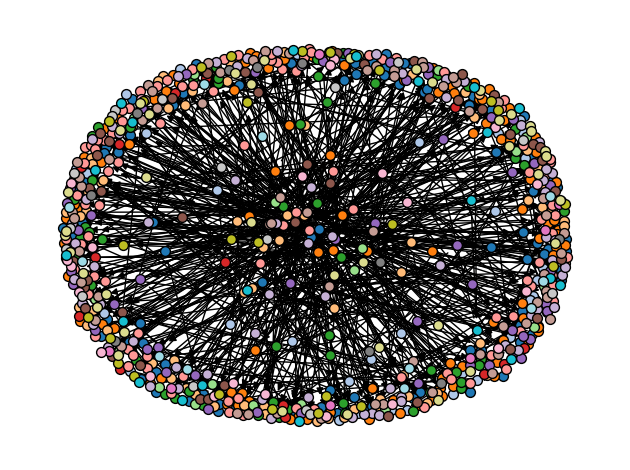

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# assume G is your DiGraph


pos = nx.spring_layout(Graph, k=0.5, iterations=50)
# alternatively: pos = nx.shell_layout(G)
# or with pygraphviz: pos = nx.nx_agraph.graphviz_layout(G, prog='dot')


# nx.draw_networkx_nodes(
#     Graph, pos,
#     node_size=150,         # adjust size
#     node_color='lightblue' # any Matplotlib color
# )
comps = list(nx.weakly_connected_components(Graph))

# build a colour palette
cmap = plt.get_cmap('tab20')
colors = [cmap(i/len(comps)) for i in range(len(comps))]


# 4) draw each component in its own colour
for i, comp in enumerate(comps):
    nx.draw_networkx_nodes(
        Graph, pos,
        nodelist=list(comp),
        edgecolors='black', 
        node_color=[colors[i]],
        node_size=50
    )
# draw edges with arrows:
nx.draw_networkx_edges(
    Graph, pos,
    arrowstyle='-|>',      # arrow head
    arrowsize=10,          # size of arrow head
    width=1
)

# # draw labels:
# nx.draw_networkx_labels(
#     Graph, pos,
#     font_size=4,
#     font_family='sans-serif'
# ):
plt.axis('off')  # turn off axes
plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 1) find components
comps = list(nx.weakly_connected_components(Graph))

# 2) build a colour palette
cmap = plt.get_cmap('tab20')
colors = [cmap(i/len(comps)) for i in range(len(comps))]

# 3) hierarchical (parent→child) layout
#    requires pygraphviz or pydot installed
pos = nx.nx_agraph.graphviz_layout(Graph, prog='dot')

# 4) draw each component in its own colour
for i, comp in enumerate(comps):
    nx.draw_networkx_nodes(
        Graph, pos,
        nodelist=list(comp),
        edgecolors='black', 
        node_color=[colors[i]],
        node_size=150
    )

# draw edges and labels once
nx.draw_networkx_edges(Graph, pos, arrowstyle='-|>', arrowsize=8, width=1)
# nx.draw_networkx_labels(Graph, pos, font_size=7)

plt.axis('off')
plt.tight_layout()
plt.show()


In [49]:
import requests
import time
import networkx as nx

BASE_URL = "https://paperswithcode.com/api/v1"

def fetch_relations(label: str, rel: str) -> list[str]:
    """Fetch either 'parents' or 'children' for a given task label."""
    url = f"{BASE_URL}/tasks/{label.replace(' ', '-').lower()}/{rel}/"
    resp = requests.get(url)
    resp.raise_for_status()
    return [e["id"] for e in resp.json().get("results", [])]

def build_task_graph(seed_labels: list[str], pause: float = 1.0) -> nx.DiGraph:
    """
    Crawl outward from each seed label, adding parent→child edges for both
    "parents" and "children" relations into one DiGraph.
    """
    G = nx.DiGraph()
    seen: set[str] = set()

    def crawl(label: str):
        if label in seen:
            return
        seen.add(label)
        G.add_node(label)

        # handle both directions in one loop
        for rel, add_edge in [
            ("parents", lambda p: G.add_edge(p, label)),   # parent → child
            ("children", lambda c: G.add_edge(label, c)),  # label → child
        ]:
            try:
                neighbors = fetch_relations(label, rel)
            except requests.HTTPError:
                continue

            for nbr in neighbors:
                G.add_node(nbr)
                add_edge(nbr)
            time.sleep(pause)

            # recurse
            for nbr in neighbors:
                crawl(nbr)

    for lbl in seed_labels:
        crawl(lbl)

    return G

if __name__ == "__main__":
    # ensure you define `unique_labels` somewhere, then:
    seeds = unique_labels[:2]
    G = build_task_graph(seeds)


KeyboardInterrupt: 

In [48]:
t = seeds[1]
print(f"Ancestors of {t}:", nx.ancestors(G, t))
print(f"Descendants of {t}:", nx.descendants(G, t))

NetworkXError: The node adversarial-attack is not in the digraph.

In [18]:
import requests

BASE_URL = "https://paperswithcode.com/api/v1"

def fetch_parents_recursive(task_label, level=0, seen=None, collected=None):
    if seen is None:
        seen = set()
    if collected is None:
        collected = []

    normalized_label = task_label.replace(' ', '-').lower()
    parents_url = f"{BASE_URL}/tasks/{normalized_label}/parents/"

    try:
        response = requests.get(parents_url)
        response.raise_for_status()
        results = response.json().get("results", [])

        for entry in results:
            name = entry["id"]
            if name not in seen:
                seen.add(name)
                collected.append((name, level))
                fetch_parents_recursive(name, level + 1, seen, collected)

    except requests.RequestException as e:
        print(f"Error fetching {parents_url}: {e}")

    return collected

# Example usage
for label in unique_labels[:50]:
    print(f"\nTask: {label}")
    parents = fetch_parents_recursive(label)
    for name, level in parents:
        indent = "  " * level
        print(f"{indent}- {name}")



Task: AI2 Reasoning Challenge

Task: ARC
- arc

Task: Active Learning
- optical-character-recognition
- active-learning

Task: Adversarial Attack
- adversarial-attack

Task: Adversarial Robustness
- adversarial-robustness

Task: Answer Selection
- question-answering

Task: Articles
- 2d-classification
- 2d-human-pose-estimation

Task: Attribute

Task: AutoML
- automl

Task: Autonomous Driving
- autonomous-vehicles

Task: BIG-bench Machine Learning
Error fetching https://paperswithcode.com/api/v1/tasks/big-bench-machine-learning/parents/: 404 Client Error: Not Found for url: https://paperswithcode.com/api/v1/tasks/big-bench-machine-learning/parents/

Task: Bayesian Inference
- bayesian-inference

Task: Benchmarking
- benchmarking
  - data-free-knowledge-distillation
    - knowledge-distillation

Task: Bias Detection
- bias-detection

Task: Bilevel Optimization
- bilevel-optimization

Task: Blocking
- entity-resolution
  - data-integration

Task: Bridging Anaphora Resolution
- anaphora-

In [29]:
import requests

BASE_URL = "https://paperswithcode.com/api/v1"


def slug(label: str) -> str:
    """
    Convert a label to the URL slug used by the API (lowercase, spaces to hyphens).
    """
    return label.strip().lower().replace(' ', '-')


def get_parent_chain(label: str, seen=None) -> list:
    """
    Recursively fetch all parent tasks of a given label until no more parents are found.

    Args:
        label: The task name string (not slugified) to fetch parents for.
        seen: A set tracking already-visited task IDs to avoid cycles.

    Returns:
        A list of parent task IDs in order from direct parent up to the root.
    """
    if seen is None:
        seen = set()

    # Build the URL for parents endpoint
    url = f"{BASE_URL}/tasks/{slug(label)}/parents/"
    try:
        response = requests.get(url)
        response.raise_for_status()
        results = response.json().get("results", [])
        print(results)
    except requests.RequestException as e:
        print(f"Error fetching parents for '{label}': {e}")
        return []

    chain = []
    # Iterate through each parent result
    for entry in results:
        parent_id = entry.get("id")
        if not parent_id or parent_id in seen:
            continue

        seen.add(parent_id)
        # Append this parent
        chain.append(parent_id)
        # Recursively fetch this parent's parents
        chain.extend(get_parent_chain(parent_id, seen))

    return chain


if __name__ == "__main__":

    # Build a dictionary mapping each label to its full parent chain
    hierarchy_tree = {}

    for label in unique_labels[:5]:  # or iterate through all labels
        parent_chain = get_parent_chain(label)
        if not parent_chain:
            print(f"'{label}' has no parents (it's a root task) or could not fetch data.")
        hierarchy_tree[label] = parent_chain

    # Display the resulting hierarchy
    for label, parents in hierarchy_tree.items():
        print(f"Task: {label}\n  Parents chain: {parents or 'None - this is a root node'}\n")


[]
'AI2 Reasoning Challenge' has no parents (it's a root task) or could not fetch data.
[{'id': 'arc', 'name': 'ARC', 'description': ''}]
[{'id': 'arc', 'name': 'ARC', 'description': ''}]
[{'id': 'optical-character-recognition', 'name': 'Optical Character Recognition (OCR)', 'description': '**Optical Character Recognition** or **Optical Character Reader** (OCR) is the electronic or mechanical conversion of images of typed, handwritten or printed text into machine-encoded text, whether from a scanned document, a photo of a document, a scene-photo (for example the text on signs and billboards in a landscape photo, license plates in cars...) or from subtitle text superimposed on an image (for example: from a television broadcast)'}, {'id': 'active-learning', 'name': 'Active Learning', 'description': '**Active Learning** is a paradigm in supervised machine learning which uses fewer training examples to achieve better optimization by iteratively training a predictor, and using the predictor

# Table extraction

data/papers_pdfs/Incorporating_Literals_into_Knowledge_Graph_Embeddings.pdf


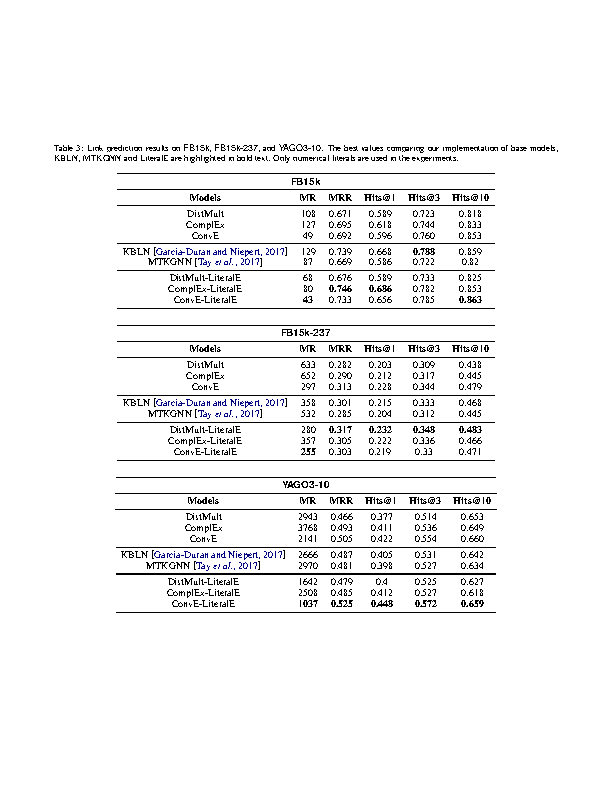

In [2]:
# extract tables from the paper
import json
import pdfplumber
# open the JSON file with paper metadata from paperswithcode
with open("../data/papers_data.json", "r", encoding="utf-8") as f:
    papers_list = json.load(f)
# remove if Local PDF Path is None
papers_list = [paper for paper in papers_list if paper.get("Local PDF Path") is not None]
pdf_path = papers_list[1]["Local PDF Path"]
print(pdf_path)
pdf = pdfplumber.open(pdf_path)

# for page in pdf.pages:
#     # Extract tables from each page
#     tables = page.extract_tables()
#     for table in tables:
#         table  # or process the table as needed
p0 = pdf.pages[5]

im = p0.to_image()
im


In [ ]:
table_settings = {
    "vertical_strategy": "text", 
    "horizontal_strategy": "lines",
    "explicit_vertical_lines": [],
    "explicit_horizontal_lines": [],
    "snap_tolerance": 3,
    "snap_x_tolerance": 3,
    "snap_y_tolerance": 3,
    "join_tolerance": 3,
    "join_x_tolerance": 3,
    "join_y_tolerance": 3,
    "edge_min_length": 3,
    "min_words_vertical": 3,
    "min_words_horizontal": 1,
    "intersection_tolerance": 3,
    "intersection_x_tolerance": 3,
    "intersection_y_tolerance": 3,
    "text_tolerance": 3,
    "text_x_tolerance": 3,
    "text_y_tolerance": 3,
}

SyntaxError: invalid character '…' (U+2026) (2747281047.py, line 21)

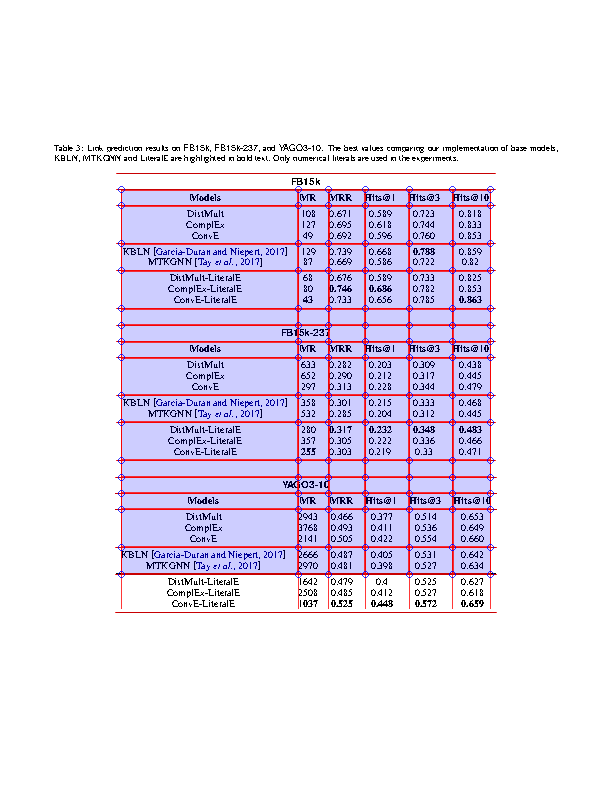

In [16]:
table = p0.to_image().debug_tablefinder(table_settings)
table

In [66]:
table = p0.extract_table(table_settings=table_settings)

In [62]:
table

In [69]:

import pandas as pd

df = pd.DataFrame(table[1:], columns=table[0])



df

,Models,MR,MRR,Hits@1,Hits@3,Hits@10
0,DistMult\nComplEx\nConvE,108\n127\n49,0.671\n0.695\n0.692,0.589\n0.618\n0.596,0.723\n0.744\n0.760,0.818\n0.833\n0.853
1,"KBLN[Garcia-DuranandNiepert,2017]\nMTKGNN[Taye...",129\n87,0.739\n0.669,0.668\n0.586,0.788\n0.722,0.859\n0.82
2,DistMult-LiteralE\nComplEx-LiteralE\nConvE-Lit...,68\n80\n43,0.676\n0.746\n0.733,0.589\n0.686\n0.656,0.733\n0.782\n0.785,0.825\n0.853\n0.863
3,,,,,,
4,FB1,5k-237,,,,
5,Models,MR,MRR,Hits@1,Hits@3,Hits@10
6,DistMult\nComplEx\nConvE,633\n652\n297,0.282\n0.290\n0.313,0.203\n0.212\n0.228,0.309\n0.317\n0.344,0.438\n0.445\n0.479
7,"KBLN[Garcia-DuranandNiepert,2017]\nMTKGNN[Taye...",358\n532,0.301\n0.285,0.215\n0.204,0.333\n0.312,0.468\n0.445
8,DistMult-LiteralE\nComplEx-LiteralE\nConvE-Lit...,280\n357\n255,0.317\n0.305\n0.303,0.232\n0.222\n0.219,0.348\n0.336\n0.33,0.483\n0.466\n0.471
9,,,,,,


### camelot